## Dependencies

In [1]:
!pip install imutils
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [0]:
# Dependencies to Visualize the model
%matplotlib inline
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd 
import random
import cv2

In [0]:
# Filepaths, numpy, and Tensorflow
import os
import numpy as np
import tensorflow as tf
import shutil
import cv2

seed = 580580
np.random.seed(seed)
tf.random.set_seed(seed)

In [32]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Keras Specific Dependencies

In [0]:
# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, Input, Dropout
from tensorflow.keras.layers import BatchNormalization, Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


# Inspect the Metadata of the Covid-19 dataset 

In [6]:
# construct the path to the metadata CSV file and load it

csvPath = "/content/drive/My Drive/covid-chest-xray/metadata.csv"
df = pd.read_csv(csvPath)
df.head(2)

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 27
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,infiltrate in the upper lobe of the left lung,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN


In [7]:
print(df.columns)

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'needed_supplemental_O2', 'extubated',
       'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count',
       'lymphocyte_count', 'view', 'modality', 'date', 'location', 'folder',
       'filename', 'doi', 'url', 'license', 'clinical_notes', 'other_notes',
       'Unnamed: 27'],
      dtype='object')


In [0]:
# Finding distribution (nan if unknown)
ax = df['finding'].value_counts(dropna=False).plot.pie(y='Finding',
                                                       legend = True,
                                                       autopct='%2.0f%%',
                                                       figsize = (10,10),
                                                       title = 'Finding Distribution')

In [0]:

# Sex distribution (nan if unknown)
ax = df['sex'].value_counts(dropna=False).plot.pie(y='sex',
                                                    legend = True,
                                                    autopct='%2.0f%%',
                                                    figsize = (5,5),
                                                    title = 'Sex Distribution')

In [0]:
# Now age (nan in unknown)
out = pd.cut(df['age'], bins=np.arange(0,110,10).tolist(), include_lowest=True)
ax = out.value_counts(sort=False, dropna=False).plot.bar(rot=0, color="b", figsize=(15,6), title= "Age Distribution")
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
plt.show()

In [0]:
# Survival 
ax = df['survival'].value_counts(dropna=False).plot.pie(y='survival',
                                                        legend = True,
                                                        autopct='%2.0f%%',
                                                        figsize = (5,5),
                                                        title = 'Survival Distribution')

# Build the list of paths to the diferent data sets

In [0]:
# construct the path to the covid xrays 
covid_dataset_path = '/content/drive/My Drive/covid-chest-xray'

# loop over the rows of the data frame to fetch covid xrays that are PA
for (i, row) in df.iterrows():
    # ignore the row if  it is not covit and PA
    
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])
    # print(imagePath)
    # if the image file listed on the csv file does not exist then ignore entry
    if not os.path.sep.join(imagePath):
      continue
    # extract the filename from the path and construct the path to the copied image file
    filename= row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"/content/drive/My Drive/data/covid", filename])
    # print(imagePath , outputPath)
    # copy the image
    shutil.copy2(imagePath, outputPath)



In [0]:
# construct the path to the xrays
xraysPath = "/content/drive/My Drive/pneumonia-chest-xray/chest_xray"
basePath = os.path.sep.join([xraysPath, "train", "NORMAL"])
imagePaths_normal = list(paths.list_images(basePath))

# ------------------------
# randomly sample the image paths
samples = 100
random.seed(580580)
random.shuffle(imagePaths_normal)
imagePaths_normal = imagePaths_normal[:samples]
# --------------------------
# print (imagePaths_normal)

# loop over the image paths
for (i, imagePath) in enumerate (imagePaths_normal):
  # print (imagePath)
  # extract the filename from the path and construct pathe to the copied image file
  filename = imagePath.split(os.path.sep)[-1]
  outputPath_normal = os.path.sep.join([f"/content/drive/My Drive/data/normal", filename])
  # print(imagePath , outputPath_normal)
  # copy the image
  shutil.copy2(imagePath, outputPath_normal)



Plot the xrays

In [0]:
# helper function to add the xrays in a grid
def ceildiv(a, b):
    return -(-a // b)

In [0]:
def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [0]:
normal_images = list(paths.list_images(f"/content/drive/My Drive/data/normal"))
covid_images = list(paths.list_images(f"/content/drive/My Drive/data/covid"))

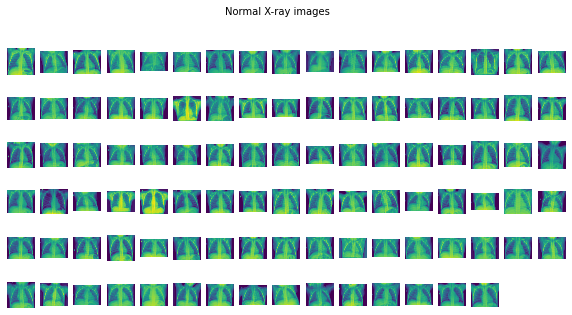

In [13]:
plots_from_files(normal_images, rows=6, maintitle="Normal X-ray images")

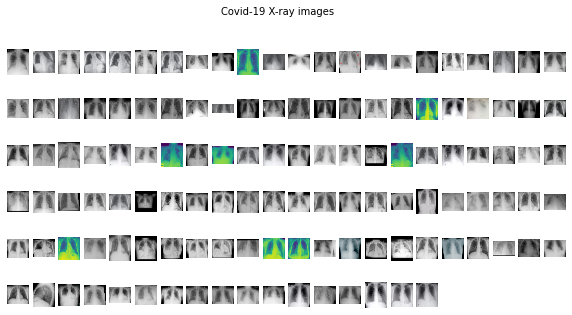

In [14]:
plots_from_files(covid_images, rows=6, maintitle="Covid-19 X-ray images")

# Load the covid/normal datasets

In [0]:
# initialize the initial learning rate, number of epochs and batch size
INIT_LR = 1e-3
EPOCHS = 10
BS = 32

In [0]:
# colect the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

imagePaths = list(paths.list_images("/content/drive/My Drive/data/"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # print(imagePath)
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image
    image = cv2.imread(imagePath)
    # color conversion from BGR to RedGreenBlue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # resize image to 224x224 pixels ignoring aspect ratio
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)



# Preprocess data

Normalize Data

In [0]:
# convert the data and labels to NumPy arrays and scale intensities 
data = np.array(data) / 255.0
labels = np.array(labels)

One-Hot Encoding

We need to one-hot encode our integer labels using the to_categorical helper function

In [0]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


Build the Train and Test detasets 

In [0]:
# partition the data into training and testing 
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=580)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

# Build the Model

Build a Deep Multi-Layer VGG16 model with two hidden layers

https://keras.io/applications/#VGG19

In [20]:
# from tensorflow.keras.applications.vgg16 import (
#     VGG16,
#     preprocess_input, 
#     decode_predictions)

# load the VGG16 network, ensuring the head FC layer sets are left off

baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)

# First layer with imput dimensions by default is the number of elements (pixels) in each immage
# activation function used is "relu"

headModel = Dense(64, activation="relu")(headModel)
# dropout to reduce overfiting
headModel = Dropout(0.5)(headModel)

# Add our final output layer where the number of nodes corresponds to the number of y labels

headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

for layer in baseModel.layers:
    layer.trainable = False

# Building Model: Compiling and Training

## Model Summary

In [22]:
# We can summarize our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Compiling  the model

In [0]:
# compile the model

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", 
              optimizer=opt, metrics=["accuracy"])

## Training Model

Training consists of updating our weights using our optimizer and loss function. Here I am using 10 iterations or epochs.

We also choose to shuffle our training data and increase the detail printed out during each training cycle.

In [24]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
5/5 [==============================] - 79s 16s/step - loss: 0.8362 - accuracy: 0.5125 - val_loss: 0.6001 - val_accuracy: 0.7826
Epoch 2/10
5/5 [==============================] - 79s 16s/step - loss: 0.7395 - accuracy: 0.5638 - val_loss: 0.5320 - val_accuracy: 0.9130
Epoch 3/10
5/5 [==============================] - 74s 15s/step - loss: 0.5776 - accuracy: 0.6980 - val_loss: 0.4752 - val_accuracy: 0.8696
Epoch 4/10
5/5 [==============================] - 73s 15s/step - loss: 0.4968 - accuracy: 0.7517 - val_loss: 0.4311 - val_accuracy: 0.8696
Epoch 5/10
5/5 [==============================] - 75s 15s/step - loss: 0.3976 - accuracy: 0.8523 - val_loss: 0.3547 - val_accuracy: 0.9348
Epoch 7/10
5/5 [==============================] - 78s 16s/step - loss: 0.3732 - accuracy: 0.8625 - val_loss: 0.3275 - val_accuracy: 0.9565
Epoch 8/10
5/5 [==============================] - 78s 16s/step - l

## Ploting training metrics with 'history' function

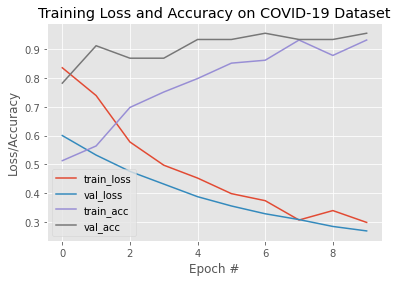

In [25]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

## EVALUATION of the model

We use our testing data to validate our model. This is how we determine the validity of our model (i.e. the ability to predict new and previously unseen data points)

In [26]:
# Model predictions 

predictions = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(predictions, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predictions, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.96      0.96      0.96        26
      normal       0.95      0.95      0.95        20

    accuracy                           0.96        46
   macro avg       0.96      0.96      0.96        46
weighted avg       0.96      0.96      0.96        46



In [28]:
# compute the confusion matrix and and use it to derive accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predictions)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[25  1]
 [ 1 19]]
acc: 0.9565
sensitivity: 0.9615
specificity: 0.9500


## Saving and Loading models

We can save our trained models using the HDF5 binary format with the extension `.h5`

In [0]:
# Save to the model to google Drive

from tensorflow.keras.models import load_model
modelFilename = "/content/drive/My Drive/dlxrayImages095.h5"
model.save(modelFilename)

In [0]:
# Load the model from Google Drive
loaded_model = load_model(modelFilename)


## Evaluating the Loaded Model



In [35]:
# Evaluate the model using the training data 

model_loss, model_accuracy = loaded_model.evaluate(testX, testY, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 6s - loss: 0.2678 - accuracy: 0.9565
Loss: 0.2677749991416931, Accuracy: 0.95652174949646


## Making Predictions

We can use our trained model to make predictions using `model.predict`

In [0]:
# Grab just one data point to test with
test = np.expand_dims(trainX[0], axis=0)
test.shape

In [0]:
plt.imshow(scaler.inverse_transform(test).reshape(224, 224), cmap=plt.cm.Greys)

In [0]:
# Make a prediction. The result should be 0000010000000 for a 5
model.predict(test).round()

In [0]:
# Grab just one data point to test with
test = np.expand_dims(X_train[2], axis=0)
test.shape

In [0]:
plt.imshow(scaler.inverse_transform(test).reshape(28, 28), cmap=plt.cm.Greys)

# Import a Custom Image

Case courtesy of Dr Fabio Macori, <a href="https://radiopaedia.org/">Radiopaedia.org</a>. From the case <a href="https://radiopaedia.org/cases/74887">rID: 74887</a>

In [0]:
filepathCustom = "/content/drive/My Drive/covid-19-pneumonia-14.png"

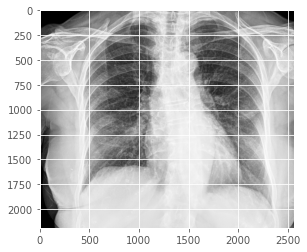

In [42]:
# load and plot the image
image = plt.imread(filepathCustom)
plt.imshow(image)

In [43]:
image.shape

(2190, 2567, 4)

In [0]:
# load the image
image = cv2.imread(filepathCustom)
# color conversion from BGR to RedGreenBlue
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# resize image to 224x224 pixels ignoring aspect ratio
image = cv2.resize(image, (224, 224))


In [45]:
image.shape

(224, 224, 3)

In [0]:
# Convert the image to a NumPy array and scale intensities

data= image = img_to_array(im)
image.shape

In [0]:
# Scale the image pixels by 255 (or use a scaler from sklearn here)
image /= 255

# Flatten into a 1x28*28 array 
img = image.flatten().reshape(-1, 28*28)
img.shape

In [0]:
plt.imshow(img.reshape(28, 28), cmap=plt.cm.Greys)

In [0]:
# Invert the pixel values to match the original data
img = 1 - img
plt.imshow(img.reshape(28, 28), cmap=plt.cm.Greys)

In [0]:
# Make predictions
model.predict_classes(img)